In [1]:
import pickle as pkl
import statistics
import time
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from fastembed import TextEmbedding
from sklearn.feature_extraction.text import TfidfVectorizer

load_dotenv()

import dataloader
import util

util.set_seed(22)

c:\Users\risko\Desktop\Prompt-Classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
datasets = dataloader.get_domain_data()
eval_datasets = dataloader.get_eval_datasets()
batch_data = dataloader.get_batch_data()

batch_sizes = [1, 32, 64, 128, 256]

In [3]:
baai_embedding = TextEmbedding(
    model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"]
)
mini_embedding = TextEmbedding(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    providers=["CUDAExecutionProvider"],
)

tfidf_embedding = TfidfVectorizer()

c:\Users\risko\Desktop\Prompt-Classification\.venv\Lib\site-packages\fastembed\common\onnx_model.py:100: RuntimeWarning: Attempt to set CUDAExecutionProvider failed. Current providers: ['CPUExecutionProvider'].If you are using CUDA 12.x, install onnxruntime-gpu via `pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/`
  warnings.warn(


In [4]:
first_dataset = next(iter(datasets.values()))["prompt"]
train_prompts = first_dataset.sample(frac=0.8, random_state=22)

tfidf_embedding.fit(train_prompts)

with open("models/tfidf.pkl", "wb") as f:
    pkl.dump(tfidf_embedding, f)

# Create embedding cache directory
os.makedirs("cache/embeddings", exist_ok=True)

In [5]:
embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

# Embedding Cache Utility Functions

In [6]:
def get_cached_embeddings(texts, model_name, domain, cache_dir="cache/embeddings"):
    """Get embeddings from cache if available, otherwise compute and cache them."""
    cache_file = f"{cache_dir}/{domain}_{model_name}_embeddings.pkl"
    
    # Check if cache exists
    if os.path.exists(cache_file):
        print(f"Loading cached embeddings for {domain} using {model_name}")
        with open(cache_file, 'rb') as f:
            return pkl.load(f)
    
    # Cache doesn't exist, compute embeddings
    print(f"Computing embeddings for {domain} using {model_name}...")
    
    if model_name == "tf_idf":
        embeddings = tfidf_embedding.transform(texts)
    else:
        # Get the appropriate embedding model
        embed_model = embedding_models[model_name]
        
        # Process in batches for better memory efficiency
        batch_size = 1  # Adjust based on available RAM
        all_embeddings = []
        
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            batch_embeddings = list(embed_model.embed(batch_texts))
            all_embeddings.extend(batch_embeddings)
            
        embeddings = np.array(all_embeddings)
    
    # Cache the results
    with open(cache_file, 'wb') as f:
        pkl.dump(embeddings, f)
    
    return embeddings

# Train

Computing embeddings for finance_train using mini...


100%|██████████| 14400/14400 [02:15<00:00, 106.15it/s]


Computing embeddings for finance_test using mini...


100%|██████████| 3600/3600 [00:34<00:00, 105.31it/s]


Embedding time for mini: 11800652.708333334 ns
Cross-validation accuracy: 0.98
Training accuracy: 1.00


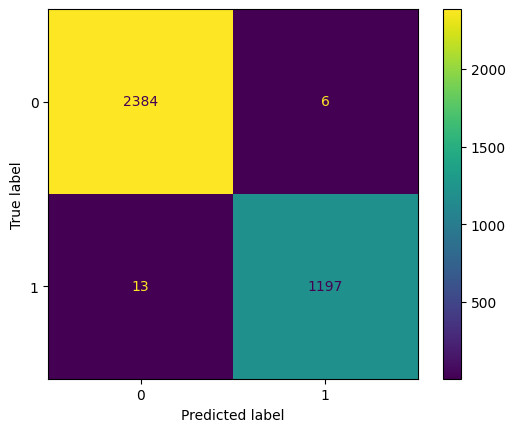

Computing embeddings for finance_train using tf_idf...
Computing embeddings for finance_test using tf_idf...
Embedding time for tf_idf: 67551.72222222222 ns
Cross-validation accuracy: 0.98
Training accuracy: 1.00


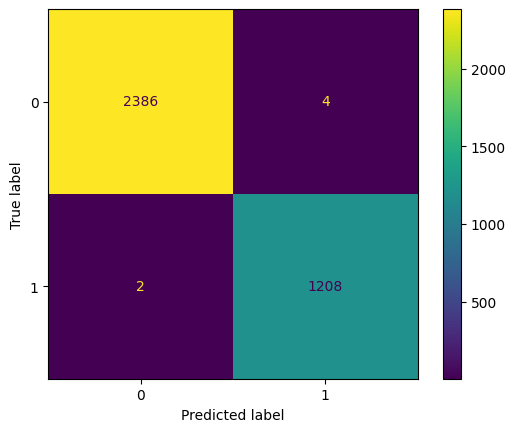

Computing embeddings for finance_train using baai...


100%|██████████| 14400/14400 [08:09<00:00, 29.44it/s]


Computing embeddings for finance_test using baai...


100%|██████████| 3600/3600 [02:01<00:00, 29.66it/s]


Embedding time for baai: 42397436.090277776 ns
Cross-validation accuracy: 1.00
Training accuracy: 1.00


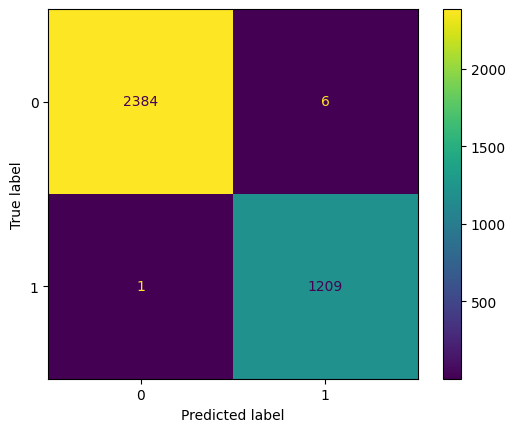

Computing embeddings for healthcare_train using mini...


100%|██████████| 14400/14400 [02:11<00:00, 109.41it/s]


Computing embeddings for healthcare_test using mini...


100%|██████████| 3600/3600 [00:35<00:00, 100.97it/s]


Embedding time for mini: 11623649.9375 ns
Cross-validation accuracy: 1.00
Training accuracy: 1.00


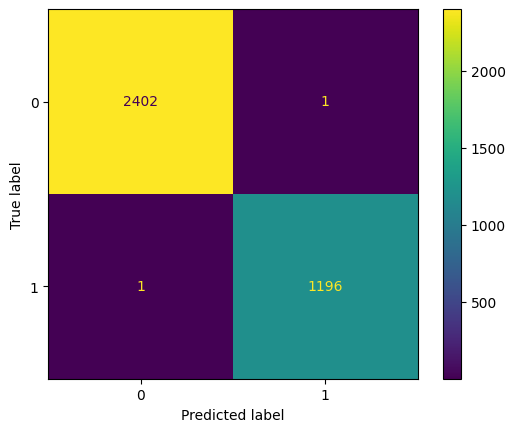

Computing embeddings for healthcare_train using tf_idf...
Computing embeddings for healthcare_test using tf_idf...
Embedding time for tf_idf: 67089.06944444444 ns
Cross-validation accuracy: 0.98
Training accuracy: 1.00


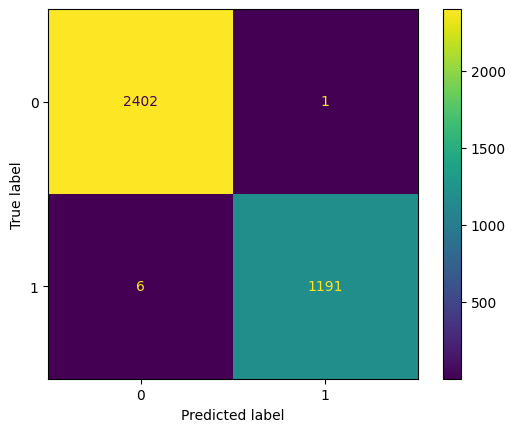

Computing embeddings for healthcare_train using baai...


100%|██████████| 14400/14400 [08:10<00:00, 29.37it/s]


Computing embeddings for healthcare_test using baai...


100%|██████████| 3600/3600 [02:03<00:00, 29.15it/s]


Embedding time for baai: 42624814.26388889 ns
Cross-validation accuracy: 1.00
Training accuracy: 1.00


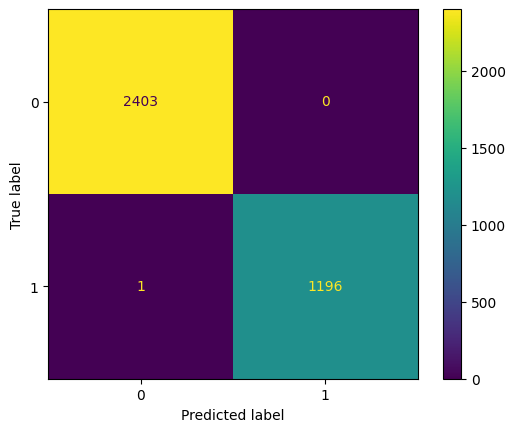

Computing embeddings for law_train using mini...


100%|██████████| 14400/14400 [02:13<00:00, 108.18it/s]


Computing embeddings for law_test using mini...


100%|██████████| 3600/3600 [00:38<00:00, 93.26it/s] 


Embedding time for mini: 11931323.270833334 ns
Cross-validation accuracy: 0.98
Training accuracy: 1.00


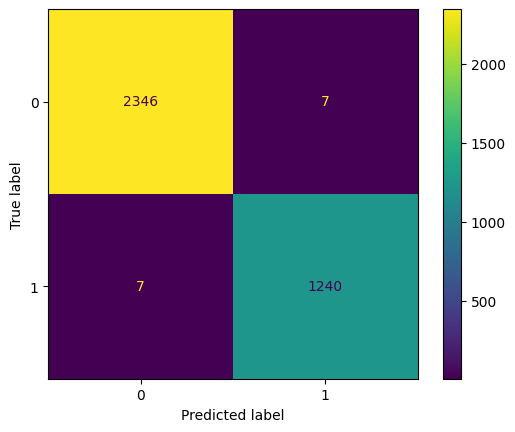

Computing embeddings for law_train using tf_idf...
Computing embeddings for law_test using tf_idf...
Embedding time for tf_idf: 70531.4375 ns
Cross-validation accuracy: 0.96
Training accuracy: 1.00


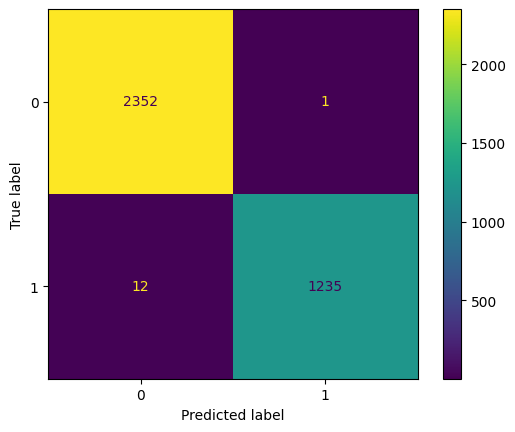

Computing embeddings for law_train using baai...


100%|██████████| 14400/14400 [08:10<00:00, 29.35it/s]


Computing embeddings for law_test using baai...


100%|██████████| 3600/3600 [02:35<00:00, 23.22it/s]


Embedding time for baai: 44842384.041666664 ns
Cross-validation accuracy: 0.99
Training accuracy: 1.00


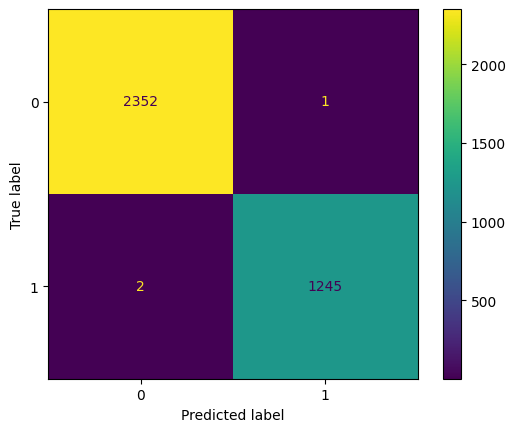

In [7]:
for domain, dataset in datasets.items():
    train_data = dataset.sample(frac=0.8, random_state=22).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    actuals = []
    predictions = []
    prediction_times = []

    for model_name, embedding_model in embedding_models.items():
        start_time = time.perf_counter_ns()
        
        # Get cached or compute new embeddings
        train_embeds = get_cached_embeddings(train_data["prompt"], model_name, f"{domain}_train")
        test_embeds = get_cached_embeddings(test_data["prompt"], model_name, f"{domain}_test")
        
        end_time = time.perf_counter_ns()
        embed_times = end_time - start_time
        mean_embed_time = embed_times / len(train_data + test_data)

        print(f"Embedding time for {model_name}: {mean_embed_time} ns")

        # Train and evaluate SVM model
        util.train_and_evaluate_model(
            model_name="SVM",
            train_embeds=train_embeds,
            test_embeds=test_embeds,
            train_labels=train_data["label"],
            test_labels=test_data["label"],
            domain=domain,
            embed_model=model_name,
            save_path=f"models/SVM_{domain}_{model_name}.pkl",
            embedding_time=mean_embed_time,
            training=True,
        )


# Eval

In [8]:
# Load TF-IDF model
with open("models/tfidf.pkl", "rb") as f:
    tfidf_embedding = pkl.load(f)

embedding_models = {
    "mini": mini_embedding,
    "tf_idf": tfidf_embedding,
    "baai": baai_embedding,
}

Loading cached embeddings for jigsaw_eval using mini


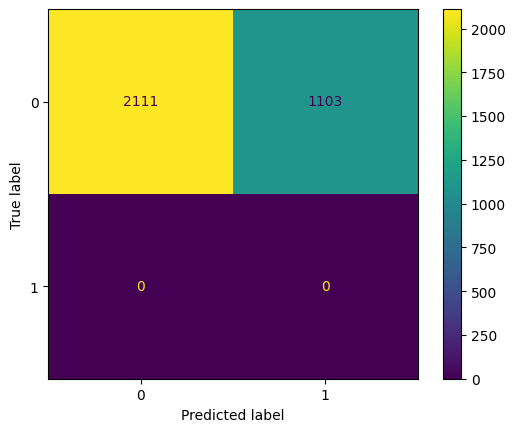

Loading cached embeddings for olid_eval using mini


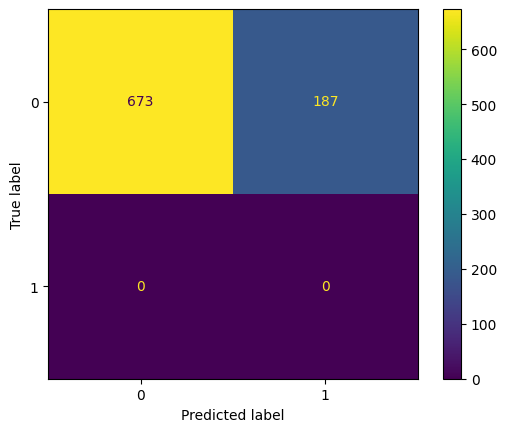

Loading cached embeddings for hate_xplain_eval using mini


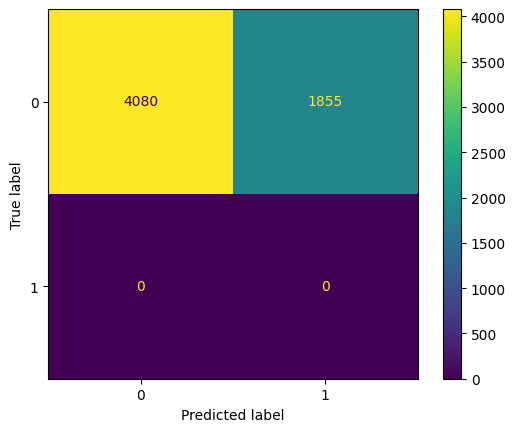

Loading cached embeddings for tuke_sk_eval using mini


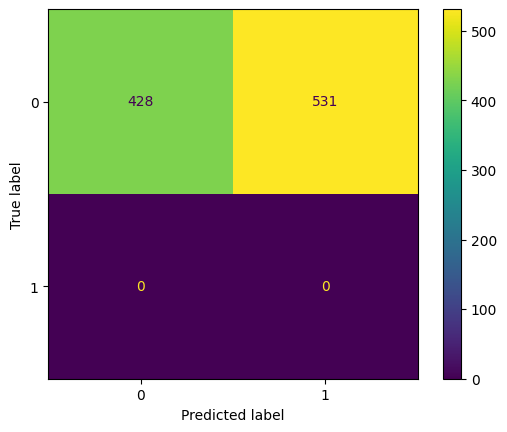

Loading cached embeddings for dkk_eval using mini


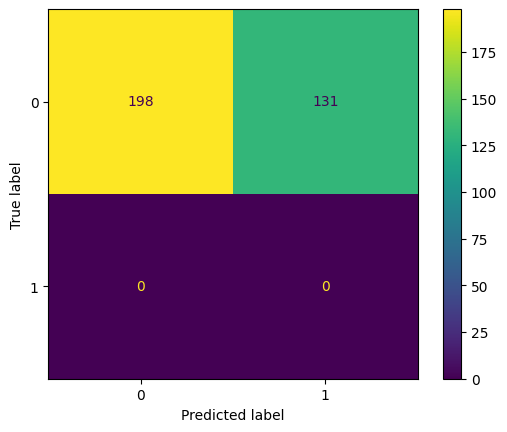

Loading cached embeddings for web_questions_eval using mini


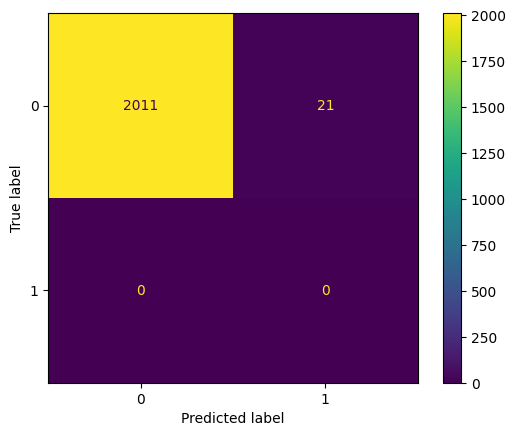

Loading cached embeddings for ml_questions_eval using mini


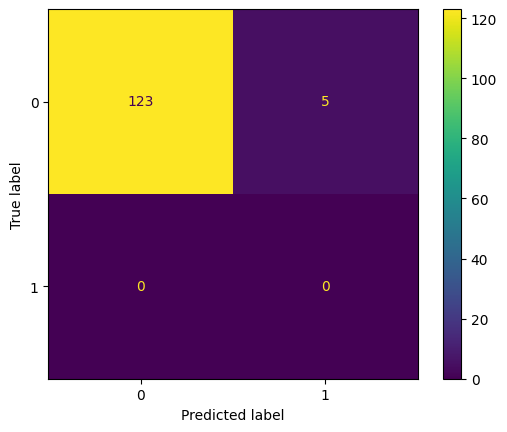

Loading cached embeddings for jigsaw_eval using tf_idf


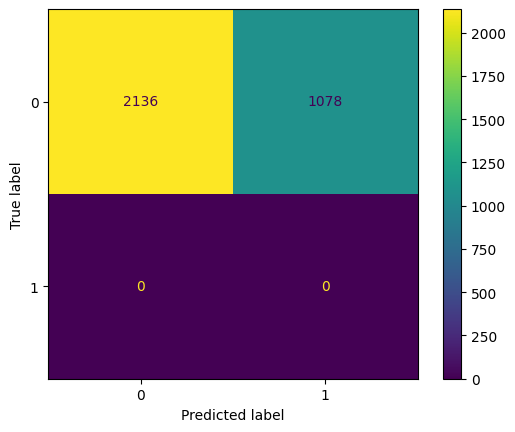

Loading cached embeddings for olid_eval using tf_idf


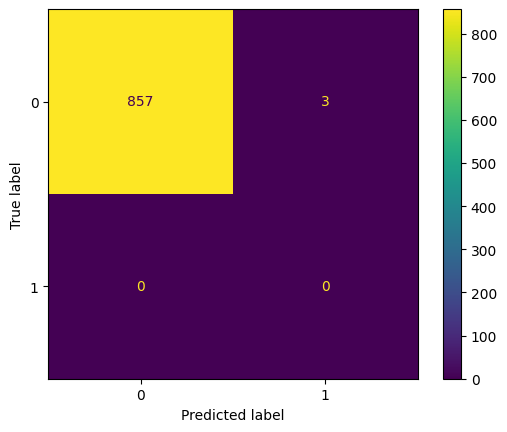

Loading cached embeddings for hate_xplain_eval using tf_idf


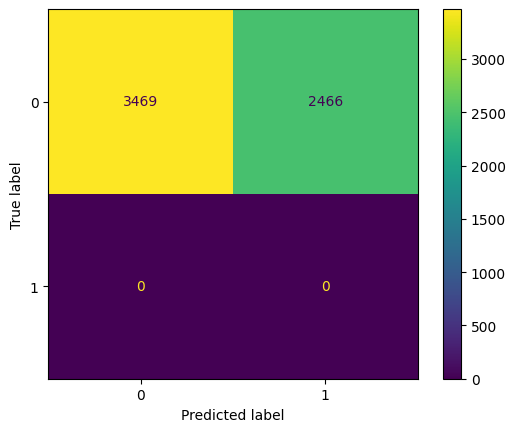

Loading cached embeddings for tuke_sk_eval using tf_idf


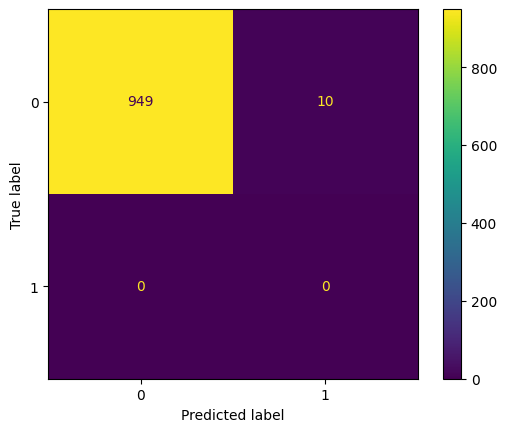

Loading cached embeddings for dkk_eval using tf_idf


c:\Users\risko\Desktop\Prompt-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


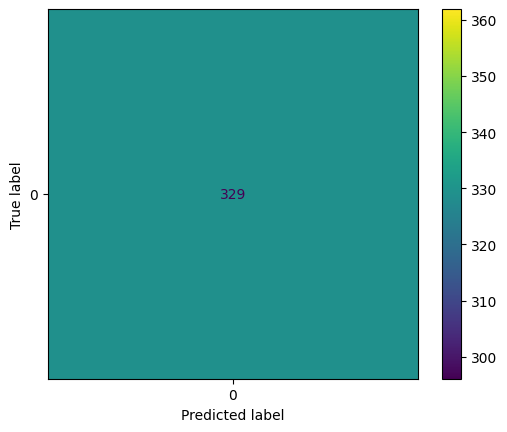

Loading cached embeddings for web_questions_eval using tf_idf


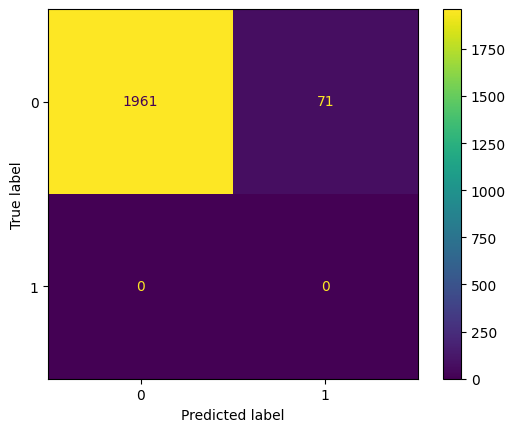

Loading cached embeddings for ml_questions_eval using tf_idf


c:\Users\risko\Desktop\Prompt-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


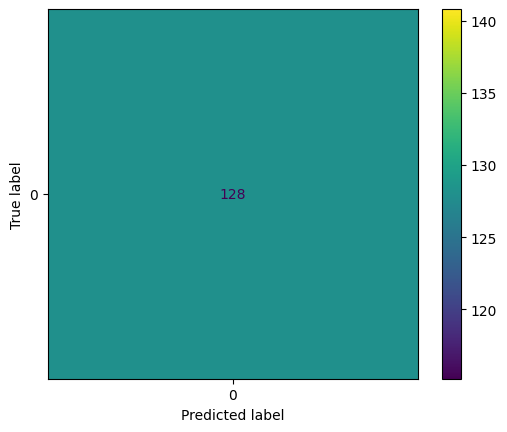

Computing embeddings for jigsaw_eval using baai...


100%|██████████| 3214/3214 [01:34<00:00, 34.12it/s]


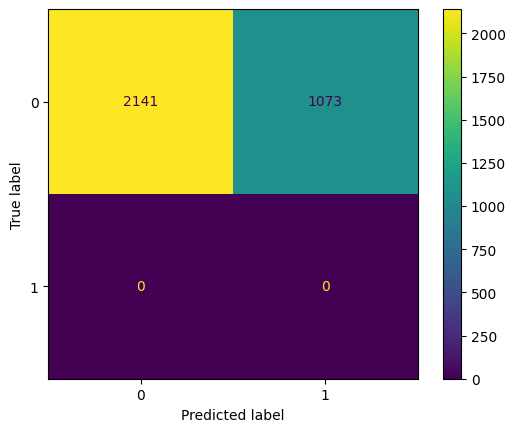

Computing embeddings for olid_eval using baai...


100%|██████████| 860/860 [00:16<00:00, 52.38it/s]


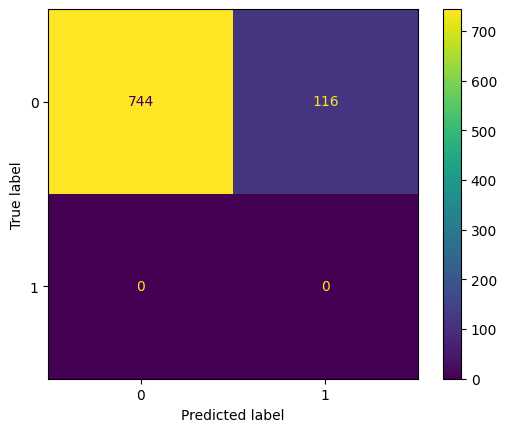

Computing embeddings for hate_xplain_eval using baai...


100%|██████████| 5935/5935 [02:06<00:00, 46.91it/s]


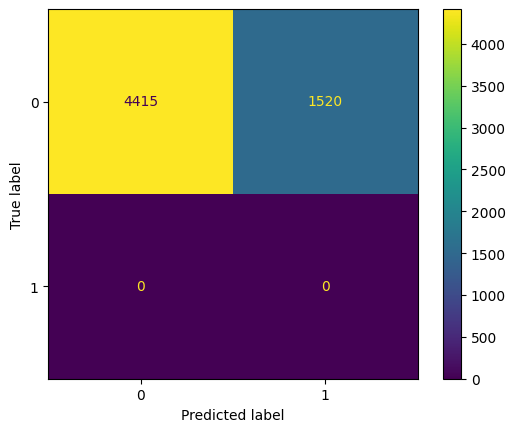

Computing embeddings for tuke_sk_eval using baai...


100%|██████████| 959/959 [00:20<00:00, 46.52it/s]


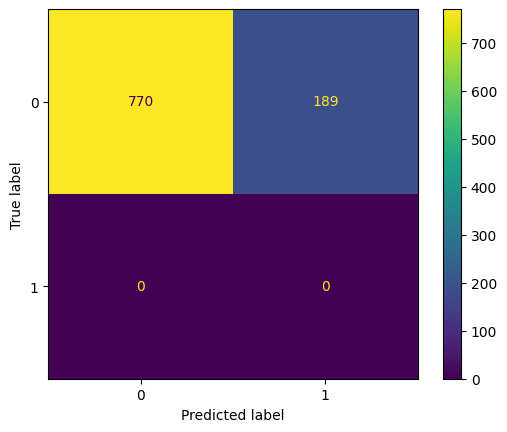

Computing embeddings for dkk_eval using baai...


100%|██████████| 329/329 [00:06<00:00, 47.71it/s]


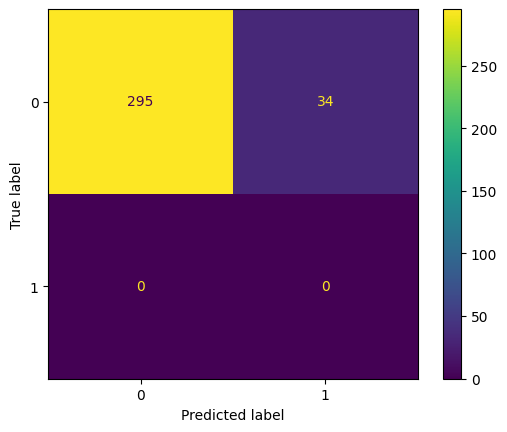

Computing embeddings for web_questions_eval using baai...


100%|██████████| 2032/2032 [00:32<00:00, 62.07it/s]


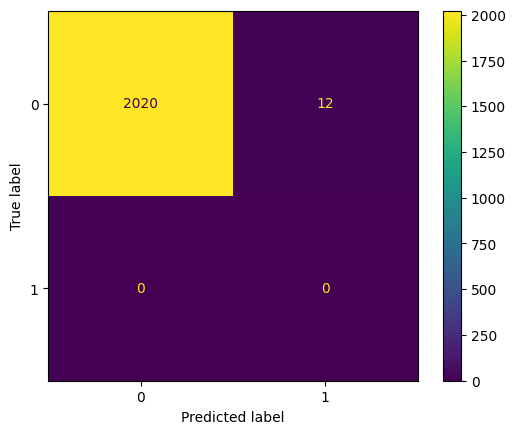

Computing embeddings for ml_questions_eval using baai...


100%|██████████| 128/128 [00:02<00:00, 52.07it/s]
c:\Users\risko\Desktop\Prompt-Classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


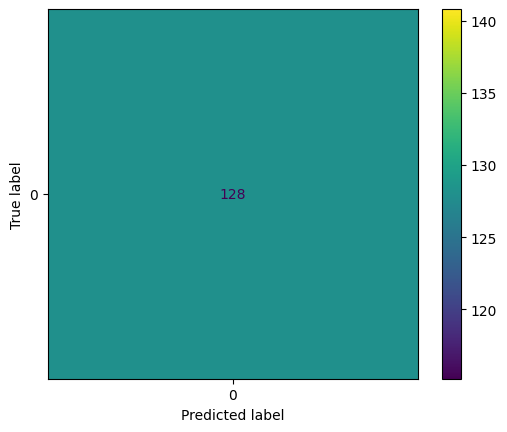

In [12]:
for embed_model_name, embedding_model in embedding_models.items():
    # Load SVM models
    with open(f"models/SVM_finance_{embed_model_name}.pkl", "rb") as f:
        svm_finance = pkl.load(f)
    with open(f"models/SVM_healthcare_{embed_model_name}.pkl", "rb") as f:
        svm_healthcare = pkl.load(f)
    with open(f"models/SVM_law_{embed_model_name}.pkl", "rb") as f:
        svm_law = pkl.load(f)

    for domain, inference_df in eval_datasets.items():
        # Get actual labels once
        actuals_ml = inference_df["label"].tolist()

        # Use cached embeddings or compute new ones
        test_embeds = get_cached_embeddings(inference_df["prompt"], embed_model_name, f"{domain}_eval")

        predictions_svm = []
        prediction_times_svm = []

        # Make batch predictions instead of one-by-one
        start_time = time.perf_counter_ns()
        pred_finance = svm_finance.predict(test_embeds)
        pred_healthcare = svm_healthcare.predict(test_embeds)
        pred_law = svm_law.predict(test_embeds)
        end_time = time.perf_counter_ns()

        # Distribute the prediction time across all samples for latency calculation
        prediction_time = end_time - start_time
        prediction_times_svm = [prediction_time / test_embeds.shape[0]] * test_embeds.shape[0]

        # Combine predictions
        predictions_svm = [
            0 if (f == 1 or h == 1 or l == 1) else 1
            for f, h, l in zip(pred_finance, pred_healthcare, pred_law, strict=True)
        ]

        # Evaluate results
        util.evaluate_run(
            predictions=predictions_svm,
            true_labels=actuals_ml,
            latency=statistics.mean(prediction_times_svm),
            domain=domain,
            embed_model=embed_model_name,
            model_name="SVM",
            train_acc=0.0,
            cost=0.0,
            training=False,
        )

# Batch

In [13]:
for embedding_model_name in ["mini", "baai", "tf_idf"]:
    svm_batch_results = []
    # Load SVM models
    with open(f"models/SVM_finance_{embedding_model_name}.pkl", "rb") as f:
        svm_finance = pkl.load(f)
    with open(f"models/SVM_healthcare_{embedding_model_name}.pkl", "rb") as f:
        svm_healthcare = pkl.load(f)
    with open(f"models/SVM_law_{embedding_model_name}.pkl", "rb") as f:
        svm_law = pkl.load(f)

    for batch_size in batch_sizes:
        print(f"Processing batch size {batch_size} with {embedding_model_name} embeddings")
        batches = [
            batch_data[i : i + batch_size]
            for i in range(0, len(batch_data), batch_size)
        ]
        for batch in tqdm(batches):
            batch_metrics = {
                "embed_time": 0,
                "svm_law_time": 0,
                "svm_finance_time": 0,
                "svm_health_time": 0,
            }

            # Time embeddings
            start_time = time.perf_counter()
            embedding_model = embedding_models[embedding_model_name]
            if embedding_model_name == "tf_idf":
                embeds = embedding_model.transform(batch)
            else:
                embeds = np.array(list(embedding_model.embed(batch)))
            batch_metrics["embed_time"] += time.perf_counter() - start_time

            # Get all predictions and time them
            start_time = time.perf_counter()
            svm_law_preds = svm_law.predict(embeds)
            batch_metrics["svm_law_time"] += time.perf_counter() - start_time

            start_time = time.perf_counter()
            svm_finance_preds = svm_finance.predict(embeds)
            batch_metrics["svm_finance_time"] += time.perf_counter() - start_time

            start_time = time.perf_counter()
            svm_health_preds = svm_healthcare.predict(embeds)
            batch_metrics["svm_health_time"] += time.perf_counter() - start_time
            
            # Combine predictions - 0 only if all predict 0
            svm_batch_preds = [
                0 if (l or f or h) else 1
                for l, f, h in zip(svm_law_preds, svm_finance_preds, svm_health_preds, strict=True)
            ]

            # Record results for this batch
            svm_batch_results.append(
                {
                    "batch_size": batch_size,
                    "time_taken_embed": batch_metrics["embed_time"],
                    "time_taken_law": batch_metrics["svm_law_time"],
                    "time_taken_finance": batch_metrics["svm_finance_time"],
                    "time_taken_healthcare": batch_metrics["svm_health_time"],
                    "results": svm_batch_preds,
                    "model_name": "svm",
                    "embedding_model": embedding_model_name,
                    "embedding": True,
                }
            )

    pd.DataFrame(svm_batch_results).to_csv(
        f"data/results/batch_svm_{embedding_model_name}.csv", index=False
    )


Processing batch size 1 with mini embeddings


100%|██████████| 1000/1000 [00:07<00:00, 126.11it/s]


Processing batch size 32 with mini embeddings


100%|██████████| 32/32 [00:00<00:00, 137.48it/s]


Processing batch size 64 with mini embeddings


100%|██████████| 16/16 [00:00<00:00, 134.97it/s]


Processing batch size 128 with mini embeddings


100%|██████████| 8/8 [00:00<00:00, 133.58it/s]


Processing batch size 256 with mini embeddings


100%|██████████| 4/4 [00:00<00:00, 129.85it/s]


Processing batch size 1 with baai embeddings


100%|██████████| 1000/1000 [00:19<00:00, 50.64it/s]


Processing batch size 32 with baai embeddings


100%|██████████| 32/32 [00:00<00:00, 52.12it/s]


Processing batch size 64 with baai embeddings


100%|██████████| 16/16 [00:00<00:00, 49.65it/s]


Processing batch size 128 with baai embeddings


100%|██████████| 8/8 [00:00<00:00, 46.61it/s]


Processing batch size 256 with baai embeddings


100%|██████████| 4/4 [00:00<00:00, 45.31it/s]


Processing batch size 1 with tf_idf embeddings


100%|██████████| 1000/1000 [00:05<00:00, 196.20it/s]


Processing batch size 32 with tf_idf embeddings


100%|██████████| 32/32 [00:00<00:00, 201.91it/s]


Processing batch size 64 with tf_idf embeddings


100%|██████████| 16/16 [00:00<00:00, 203.17it/s]


Processing batch size 128 with tf_idf embeddings


100%|██████████| 8/8 [00:00<00:00, 197.10it/s]


Processing batch size 256 with tf_idf embeddings


100%|██████████| 4/4 [00:00<00:00, 195.91it/s]
